In [57]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns


if torch.cuda.is_available():
    print("CUDA is available")
else:
    print("CUDA is not available")
    
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

print("Running on " + torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu")

CUDA is available
Running on NVIDIA GeForce GTX 1060 6GB


# Random Forests Route - Score: 0.77033

First Importing the Data

In [58]:
train_data = pd.read_csv('train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [59]:
test_data = pd.read_csv('test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [60]:
from sklearn.ensemble import RandomForestClassifier

y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch", 'Embarked']
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])


rfc = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
rfc.fit(X, y)
predictions = rfc.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('titanic_submission.csv', index=False)
print("Your submission was successfully saved!")



Your submission was successfully saved!


# Deep Learning Approach

Cleaning the data first

In [61]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Determine Title from Name
train_data['Title'] = train_data['Name'].apply(lambda x: x.split('.')[0].split(' ')[-1].strip())
test_data['Title'] = test_data['Name'].apply(lambda x: x.split('.')[0].split(' ')[-1].strip())

# Drop unnecessary columns
train_data.drop(columns=['PassengerId','Name','Ticket'], inplace=True)
test_data.drop(columns=['PassengerId','Name','Ticket'], inplace=True)

# Transform Cabin into binary 'HasCabin'
train_data['Cabin'] = train_data['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test_data['Cabin'] = test_data['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

# One-hot encode 'Pclass', 'Sex', 'SibSp', 'Parch', 'Title' and 'Embarked'
train_data = pd.get_dummies(train_data, columns=['Pclass', 'Sex', 'SibSp', 'Parch', 'Title','Embarked'])
test_data = pd.get_dummies(test_data, columns=['Pclass', 'Sex', 'SibSp', 'Parch', 'Title','Embarked'])

train_data['Age'] = train_data['Age'].fillna(train_data['Age'].median())
test_data['Age'] = test_data['Age'].fillna(test_data['Age'].median())

# Z-Score normalisation of 'Age' and 'Fare'
for column_to_normalise in ['Age', 'Fare']:
    mean_value = train_data[column_to_normalise].mean()
    std_value = train_data[column_to_normalise].std()
    train_data[column_to_normalise] = (train_data[column_to_normalise] - mean_value) / std_value
    test_data[column_to_normalise] = (test_data[column_to_normalise] - mean_value) / std_value
    
train_data.head()
test_data.head()


,Age,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,...,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Embarked_C,Embarked_Q,Embarked_S
0,0.394665,-0.490508,0,False,False,True,False,True,True,False,...,False,False,False,True,False,False,False,False,True,False
1,1.354749,-0.507194,0,False,False,True,True,False,False,True,...,False,False,False,False,True,False,False,False,False,True
2,2.506849,-0.453112,0,False,True,False,False,True,True,False,...,False,False,False,True,False,False,False,False,True,False
3,-0.181385,-0.473739,0,False,False,True,False,True,True,False,...,False,False,False,True,False,False,False,False,False,True
4,-0.565419,-0.400792,0,False,False,True,True,False,False,True,...,False,False,False,False,True,False,False,False,False,True


In [62]:
train_columns = set(train_data.columns)
test_columns = set(test_data.columns)

# Ensure both datasets have the same columns
all_columns = train_columns.union(test_columns)

# Add missing columns to train_data and set their values to False
for column in all_columns:
    if column not in train_columns:
        train_data[column] = False

# Add missing columns to test_data and set their values to False
for column in all_columns:
    if column not in test_columns:
        test_data[column] = False


train_data = train_data[sorted(train_data.columns)]
test_data = test_data[sorted(test_data.columns)]

In [63]:
import collections

dropout_prob = 0.2
weight_decay = 1e-5


input_size = 44
hidden_layer_sizes = [256, 512, 512, 256]


model_dense = nn.Sequential(collections.OrderedDict([
    ('hidden1', nn.Linear(input_size, hidden_layer_sizes[0])),
    ('activation1', nn.ReLU()),
    ('dropout1', nn.Dropout(dropout_prob)),  
    ('hidden2', nn.Linear(hidden_layer_sizes[0], hidden_layer_sizes[1])),
    ('activation2', nn.ReLU()),
    ('dropout2', nn.Dropout(dropout_prob)),
    ('hidden3', nn.Linear(hidden_layer_sizes[1], hidden_layer_sizes[2])),
    ('activation3', nn.ReLU()),
    ('dropout3', nn.Dropout(dropout_prob)),
    ('hidden4', nn.Linear(hidden_layer_sizes[2], hidden_layer_sizes[3])),
    ('activation4', nn.ReLU()),
    ('dropout4', nn.Dropout(dropout_prob)),
    ('output', nn.Linear(hidden_layer_sizes[3], 1)),
    ('activation5', nn.Sigmoid())
]))


simple_hl_sizes = [8]
model_simple = nn.Sequential(collections.OrderedDict([
    ('hidden1', nn.Linear(input_size, simple_hl_sizes[0])),
    ('activation1', nn.ReLU()),
    ('dropout1', nn.Dropout(dropout_prob)),
    ('output', nn.Linear(simple_hl_sizes[0], 1)),
    ('activation4', nn.Sigmoid())
        ]))


loss_fn = nn.BCELoss()
optimizer_dense = torch.optim.Adam(model_dense.parameters(), weight_decay=weight_decay)
optimizer_simple = torch.optim.Adam(model_simple.parameters(), weight_decay=weight_decay)
model_dense.load_state_dict(torch.load('titanic_overfit.pth'))

print("Dense MLP Model with L2 regularization and Dropout")
print(model_dense)
print("\n\n")
print("Simple MLP Model with L2 regularization and Dropout")
print(model_simple)

Dense MLP Model with L2 regularization and Dropout
Sequential(
  (hidden1): Linear(in_features=44, out_features=256, bias=True)
  (activation1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (hidden2): Linear(in_features=256, out_features=512, bias=True)
  (activation2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (hidden3): Linear(in_features=512, out_features=512, bias=True)
  (activation3): ReLU()
  (dropout3): Dropout(p=0.2, inplace=False)
  (hidden4): Linear(in_features=512, out_features=256, bias=True)
  (activation4): ReLU()
  (dropout4): Dropout(p=0.2, inplace=False)
  (output): Linear(in_features=256, out_features=1, bias=True)
  (activation5): Sigmoid()
)



Simple MLP Model with L2 regularization and Dropout
Sequential(
  (hidden1): Linear(in_features=44, out_features=8, bias=True)
  (activation1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (output): Linear(in_features=8, out_features=1, bias=True)
  (activation4): Sigmoid()
)


In [64]:
y_train = torch.tensor(train_data["Survived"].values.astype('float32')).reshape(-1,1)
X_train = torch.tensor(train_data.drop(columns=["Survived"]).values.astype('float32'))
X_test = torch.tensor(test_data.drop(columns=["Survived"]).values.astype('float32'))

print(y_train.type(), X_train.type(), X_test.type())
print(X_train.shape, y_train.shape, X_test.shape)

torch.FloatTensor torch.FloatTensor torch.FloatTensor
torch.Size([891, 44]) torch.Size([891, 1]) torch.Size([418, 44])


In [65]:
from sklearn.model_selection import StratifiedKFold
import torch
import torch.optim as optim
import torch.nn as nn
import datetime

def cross_validate(model, n_epochs, optimizer, loss_fn, X_train, y_train, n_splits=9, batch_size=32, shuffle=True, device=device,epoch_print_gap = 1):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=42)
    fold_results = []
    train_results = []

    for fold, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
        print(f"Fold {fold+1}/{n_splits}")
        X_train_fold, X_valid_fold = X_train[train_index], X_train[valid_index]
        y_train_fold, y_valid_fold = y_train[train_index], y_train[valid_index]
        
        train_dataset = torch.utils.data.TensorDataset(X_train_fold, y_train_fold)
        valid_dataset = torch.utils.data.TensorDataset(X_valid_fold, y_valid_fold)

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

        model = model.to(device)

        for epoch in range(1, n_epochs + 1):
            model.train()
            loss_train = 0.0
            correct = 0
            total = 0
            for X_train_batch, y_train_batch in train_loader:
                X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_train_batch)
                loss = loss_fn(outputs, y_train_batch)
                loss.backward()
                optimizer.step()
                loss_train += loss.item()
                total += y_train_batch.size(0)
                correct += ((outputs > 0.5).float() == y_train_batch).sum().item()
                
                
                
                
            accuracy_train = 100 *correct / total

            if epoch == 1 or epoch % epoch_print_gap == 0:
                print('{} Epoch {}, Training loss {}, Training Accuracy {:.2f}%'.format(
                    datetime.datetime.now(), epoch, float(loss_train), float(accuracy_train)))
        train_results.append(accuracy_train)

        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for X_valid_batch, y_valid_batch in valid_loader:
                X_valid_batch, y_valid_batch = X_valid_batch.to(device), y_valid_batch.to(device)
                outputs = model(X_valid_batch)
                predicted = (outputs > 0.5).float()
                total += y_valid_batch.size(0)
                correct += (predicted == y_valid_batch).sum().item()
   
                

                
        fold_accuracy = 100 *correct / total
        print('Fold Accuracy: {:.2f}%'.format(fold_accuracy))
        fold_results.append(fold_accuracy)

    return (train_results, fold_results)

In [66]:
n_epochs = 50
train, test = cross_validate(model = model_dense,
               n_epochs = n_epochs,
               optimizer = optimizer_dense,
               loss_fn = loss_fn,
               X_train = X_train,
               y_train = y_train,
               n_splits=5, 
               batch_size=32, 
               shuffle=True, 
               device=device,
               epoch_print_gap=10)


Fold 1/5
2024-02-11 20:43:15.933713 Epoch 1, Training loss 307.2314693927765, Training Accuracy 78.37%
2024-02-11 20:43:16.423521 Epoch 10, Training loss 175.4782387847954, Training Accuracy 79.49%
2024-02-11 20:43:16.968741 Epoch 20, Training loss 94.28002350777388, Training Accuracy 82.02%


2024-02-11 20:43:17.512022 Epoch 30, Training loss 72.16690720617771, Training Accuracy 83.43%
2024-02-11 20:43:18.050607 Epoch 40, Training loss 97.71007114648819, Training Accuracy 80.90%
2024-02-11 20:43:18.589063 Epoch 50, Training loss 49.219271406531334, Training Accuracy 82.72%
Fold Accuracy: 84.92%
Fold 2/5
2024-02-11 20:43:18.647921 Epoch 1, Training loss 50.22479738295078, Training Accuracy 83.87%
2024-02-11 20:43:19.138862 Epoch 10, Training loss 37.6967071890831, Training Accuracy 84.71%
2024-02-11 20:43:19.682771 Epoch 20, Training loss 49.15202981233597, Training Accuracy 83.45%
2024-02-11 20:43:20.226477 Epoch 30, Training loss 22.66711051762104, Training Accuracy 86.96%
2024-02-11 20:43:20.767660 Epoch 40, Training loss 10.994400031864643, Training Accuracy 87.10%
2024-02-11 20:43:21.308877 Epoch 50, Training loss 10.24284379184246, Training Accuracy 87.80%
Fold Accuracy: 86.52%
Fold 3/5
2024-02-11 20:43:21.367559 Epoch 1, Training loss 25.726189002394676, Training Accu

(0.0, 100.0)

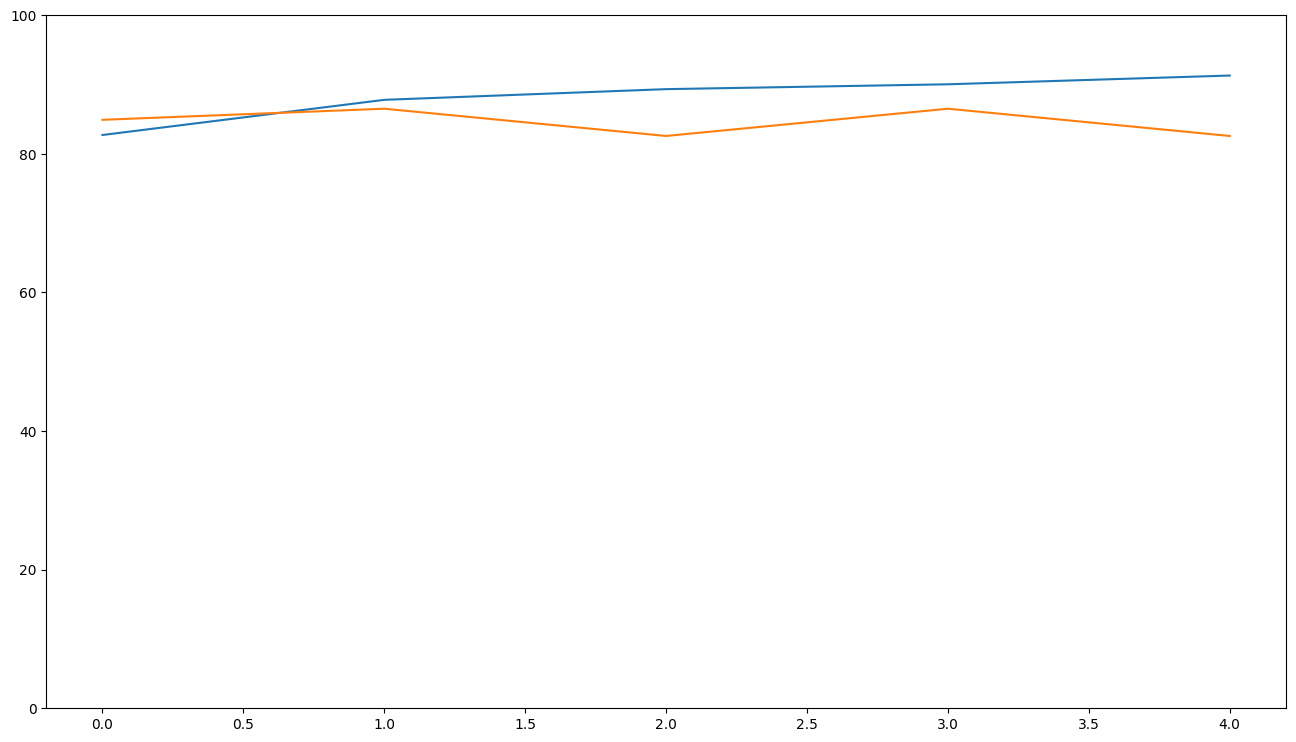

In [67]:
plt.figure(figsize=(16,9))
plt.plot(train, label="Training Accuracy")
plt.plot(test, label="Validation Accuracy")
plt.ylim(0,100)

In [72]:
model_dense = model_dense.to(device)
X_test = X_test.to(device)

model_dense.eval()
with torch.no_grad():
    y_pred = model_dense(X_test)
    predictions = (y_pred > 0.5).float()


test_ = pd.read_csv('test.csv')
output = test_[['PassengerId']]
output.loc[:, 'Survived'] = predictions.cpu().numpy().astype(int)

output.to_csv('titanic_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


/tmp/ipykernel_43552/2682251744.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output.loc[:, 'Survived'] = predictions.cpu().numpy().astype(int)


In [69]:
#torch.save(model_dense.state_dict(), 'titanic_with_dropout_l2.pth')